In [1]:
# --- Core scientific and image libraries ---
%pip install nibabel opencv-python-headless Pillow tqdm

# --- Ensure numpy < 2 to avoid matplotlib/pytorch issues ---
%pip install "numpy<2"

# --- Torch + torchvision (CUDA 11.8 compatible versions) ---
%pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu118

# --- Optional but useful for progress tracking / model hub ---
%pip install huggingface_hub

# --- Ensure jupyter is available in this env (not system) ---
%pip install jupyter ipykernel
!python -m ipykernel install --user --name=liver_diff --display-name "Python (liver_diff)"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 37.9 MB/s  0:00:00m0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.8.2 requires numpy<2,>=1.21, but you have numpy 2.2.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.2 MB/s  0:00:00m0:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless

In [2]:
import torch
print(torch.__version__)        # Should be 2.3.1
print(torch.version.cuda)       # Should be 11.8
print(torch.cuda.is_available())  # Should be True if GPU is detected
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


/home/ie643_lambdaforce/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:56: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


2.3.1+cu118
11.8
True
NVIDIA GeForce RTX 4090


In [ ]:
import zipfile
import os

# Path to your zip file
zip_path = "Training_Batch2.zip"

# Target extraction directory
extract_dir = "Training_Batch2"

# Step 1: Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 2: Move only the contents of the required subfolder
src_path = os.path.join(extract_dir, "media", "nas", "01_Datasets", "CT", "LITS", "Training Batch 2")
dst_path = "Training_Batch2"

os.makedirs(dst_path, exist_ok=True)

# Move all files from that nested directory to target
for root, dirs, files in os.walk(src_path):
    for file in files:
        src_file = os.path.join(root, file)
        dst_file = os.path.join(dst_path, file)
        os.rename(src_file, dst_file)

print("✅ Files extracted to:", dst_path)


In [3]:
import torch
import os

# Make all GPUs visible (Kaggle usually provides 2)
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join(str(i) for i in range(torch.cuda.device_count()))

# Memory optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

def setup_multiple_gpus(model):
    """Wrap model in DataParallel if multiple GPUs are available"""
    n_gpus = torch.cuda.device_count()
    if n_gpus > 1:
        print(f"Using {n_gpus} GPUs with DataParallel")
        model = torch.nn.DataParallel(model)
    else:
        print(f"Using {n_gpus} GPU")
    return model

def clear_memory():
    """Clear CUDA memory"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def print_memory_usage():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Cached: {cached:.2f} GB")

# --- Clear initial memory ---
clear_memory()
print(torch.cuda.device_count())
# Example usage with your model
# model = MyModel().cuda()
# model = setup_multiple_gpus(model)
# print_memory_usage()


2


In [4]:
from pathlib import Path
import shutil, os

ROOT = Path('Training_datasets')
DATASET_IN = Path('Training_Batch2')
OUT =  ROOT / 'prepared_dataset'
IMG_DIR = OUT / 'images'
MASK_DIR = OUT / 'masks'

# remove previous prepared folder if exists (idempotent)
if OUT.exists():
    shutil.rmtree(OUT)
IMG_DIR.mkdir(parents=True, exist_ok=True)
MASK_DIR.mkdir(parents=True, exist_ok=True)

print("Input dataset dir:", DATASET_IN)
print("Prepared output root:", OUT)


Input dataset dir: Training_Batch2
Prepared output root: Training_datasets/prepared_dataset


## Preprocessing part

In [5]:
from pathlib import Path

# check dataset folder
print("Dataset exists:", DATASET_IN.exists())
print("Number of files found:", len(list(DATASET_IN.glob('**/*.nii'))))

# list first few files
for i, f in enumerate(DATASET_IN.glob('**/*.nii')):
    if i >= 5:
        break
    print(f)


Dataset exists: True
Number of files found: 206
Training_Batch2/volume-50.nii
Training_Batch2/segmentation-30.nii
Training_Batch2/volume-49.nii
Training_Batch2/segmentation-64.nii
Training_Batch2/volume-111.nii


In [ ]:
import nibabel as nib
from pathlib import Path

files = sorted([p for p in DATASET_IN.glob('**/volume-*.nii')])
max_z = 0
for p in files:
    vol = nib.load(str(p)).get_fdata()
    if vol.ndim == 3:
        z_dim = vol.shape[2] if vol.shape[2] < vol.shape[0] else vol.shape[0]  # crude check
        max_z = max(max_z, z_dim)

print("Maximum Z (slices) across all volumes:", max_z)


In [ ]:
import nibabel as nib
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm

def preprocess_volume_soft(vol, clip_min=-100, clip_max=300, out_size=(512,512), gamma=2.0):
    # Step 1: Clip voxel intensities
    vol = np.clip(vol, clip_min, clip_max)
    
    # Step 2: Rescale to [0,255]
    vol = (vol - clip_min) / (clip_max - clip_min)
    vol = (vol * 255).astype(np.float32)
    
    # Step 3: Gamma correction (squaring)
    vol = np.power(vol / 255.0, gamma)
    
    # Step 4: Re-rescale to [0,255]
    vol = (vol * 255).astype(np.uint8)
    
    # Step 5: Resize each slice
    return np.stack([cv2.resize(s, out_size, interpolation=cv2.INTER_LINEAR) for s in vol])

def preprocess_mask_soft(seg, out_size=(512,512), blur_radius=1):
    seg_bin = (seg > 0).astype(np.float32)
    seg_blur = np.stack([cv2.GaussianBlur(s, (3,3), blur_radius) for s in seg_bin])
    seg_blur = (seg_blur * 255).astype(np.uint8)
    return np.stack([cv2.resize(s, out_size, interpolation=cv2.INTER_LINEAR) for s in seg_blur])

# Collect volumes and segmentations, sort numerically
vol_files = sorted([p for p in DATASET_IN.glob('**/volume-*.nii')], key=lambda x: int(''.join(filter(str.isdigit, x.stem))))
seg_files = sorted([p for p in DATASET_IN.glob('**/segmentation-*.nii')], key=lambda x: int(''.join(filter(str.isdigit, x.stem))))

slice_count = 0
for vol_path, seg_path in tqdm(zip(vol_files, seg_files), total=len(vol_files)):
    vol_nii = nib.load(str(vol_path)).get_fdata()
    seg_nii = nib.load(str(seg_path)).get_fdata()

    # Normalize orientation (Z,H,W)
    if vol_nii.shape[2] < 512:
        vol_nii = np.transpose(vol_nii, (2,0,1))
    if seg_nii.shape[2] < 512:
        seg_nii = np.transpose(seg_nii, (2,0,1))

    # Skip if no liver portion
    if np.sum(seg_nii > 0) < 1000:
        print(f"Skipping {vol_path.name}: no discernible liver portion")
        continue

    vol_proc = preprocess_volume_soft(vol_nii)
    seg_proc = preprocess_mask_soft(seg_nii)

    # Save slices
    for i in range(vol_proc.shape[0]):
        img_path = IMG_DIR / f'{vol_path.stem}_slice_{i:04d}.png'
        m_path = MASK_DIR / f'{seg_path.stem}_slice_{i:04d}.png'
        cv2.imwrite(str(img_path), vol_proc[i])
        cv2.imwrite(str(m_path), seg_proc[i])
        slice_count += 1

print("Saved slices:", slice_count)


100%|██████████| 103/103 [54:59<00:00, 32.04s/it] 

Saved slices: 33841


In [7]:
vol_files = sorted(DATASET_IN.glob('**/volume-*.nii'))
seg_files = sorted(DATASET_IN.glob('**/segmentation-*.nii'))

Using volume: volume-100.nii
Using mask: segmentation-100.nii


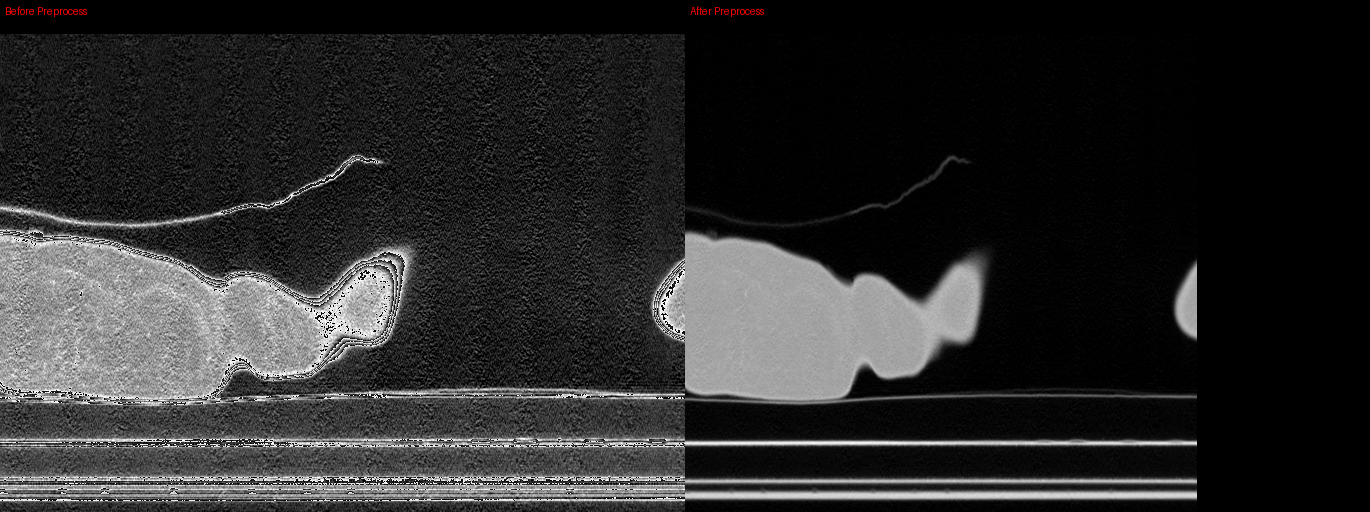

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from IPython.display import display

sample_vol_path = vol_files[0]
sample_seg_path = seg_files[0]

print("Using volume:", sample_vol_path.name)
print("Using mask:", sample_seg_path.name)


# load original volume and mask
import nibabel as nib
vol_nii = nib.load(str(sample_vol_path)).get_fdata()
seg_nii = nib.load(str(sample_seg_path)).get_fdata()

# take first slice for visualization
vol_slice = vol_nii[:,:,0] if vol_nii.shape[2] < 512 else vol_nii[0,:,:]
seg_slice = seg_nii[:,:,0] if seg_nii.shape[2] < 512 else seg_nii[0,:,:]

# preprocess slice
def preprocess_slice(vol, seg, clip_min=-1000, clip_max=400, out_size=(512,512)):
    vol = np.clip(vol, clip_min, clip_max)
    vol = ((vol - clip_min) / (clip_max - clip_min) * 255).astype(np.uint8)
    vol_img = Image.fromarray(cv2.resize(vol, out_size))
    seg_img = Image.fromarray(cv2.resize((seg>0).astype('uint8')*255, out_size, interpolation=cv2.INTER_NEAREST))
    return vol_img, seg_img

vol_proc_img, seg_proc_img = preprocess_slice(vol_slice, seg_slice)

# function to overlay mask on image
def overlay_mask(img, mask, color=(255,0,0)):
    img_rgb = img.convert("RGB")
    mask_array = np.array(mask) > 0
    overlay = np.array(img_rgb)
    overlay[mask_array, 0] = color[0]
    overlay[mask_array, 1] = color[1]
    overlay[mask_array, 2] = color[2]
    return Image.fromarray(overlay)

# create overlays
overlay_before = overlay_mask(Image.fromarray(vol_slice.astype(np.uint8)), Image.fromarray((seg_slice>0).astype(np.uint8)*255))
overlay_after = overlay_mask(vol_proc_img, seg_proc_img)

# label images
def add_label(im, text):
    im = im.convert("RGB")
    draw = ImageDraw.Draw(im)
    try:
        font = ImageFont.truetype("arial.ttf", 18)
    except:
        font = ImageFont.load_default()
    draw.text((5,5), text, fill=(255,0,0), font=font)
    return im

overlay_before = add_label(overlay_before, "Before Preprocess")
overlay_after = add_label(overlay_after, "After Preprocess")

# combine side by side
combined = Image.new("RGB", (overlay_before.width*2, overlay_before.height))
combined.paste(overlay_before, (0,0))
combined.paste(overlay_after, (overlay_before.width,0))

display(combined)


### Final Pipeline

In [ ]:
!pip install matplotlib

In [8]:
# Cell 1: Imports and utility functions

import os
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import torch

def show_slice(ct_slice, mask=None, title="CT Slice"):
    img = ct_slice.copy()
    if mask is not None:
        img = cv2.addWeighted(img.astype(np.uint8), 0.7, (mask*255).astype(np.uint8), 0.3, 0)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def read_nii(path):
    return nib.load(path).get_fdata()
    
def save_nii(volume, path):
    nii_img = nib.Nifti1Image(volume, affine=np.eye(4))
    nib.save(nii_img, path)

# -------------------- NEW UTILITIES --------------------

def save_checkpoint(model, optimizer, epoch, loss, path):
    """Save model + optimizer state."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss,
    }, path)
    print(f"Checkpoint saved: {path}")

def load_checkpoint(model, optimizer, path, device="cuda"):
    """Load model + optimizer state if checkpoint exists."""
    if not os.path.exists(path):
        print("No checkpoint found at", path)
        return 0, float('inf')
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Loaded checkpoint '{path}' (epoch {epoch}, loss {loss:.4f})")
    return epoch, loss


## Impainting Section

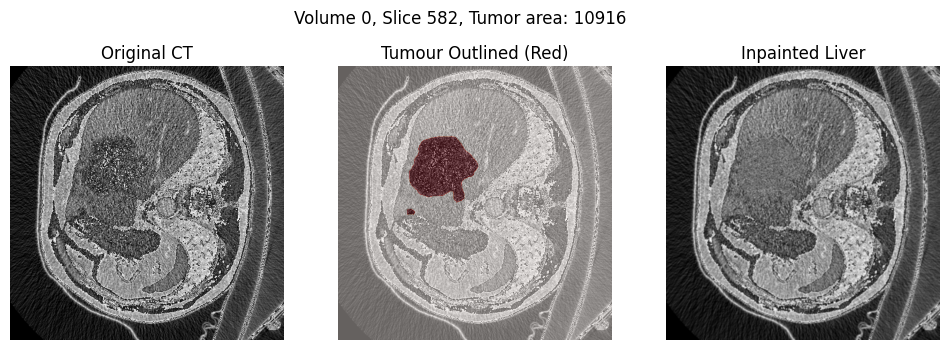

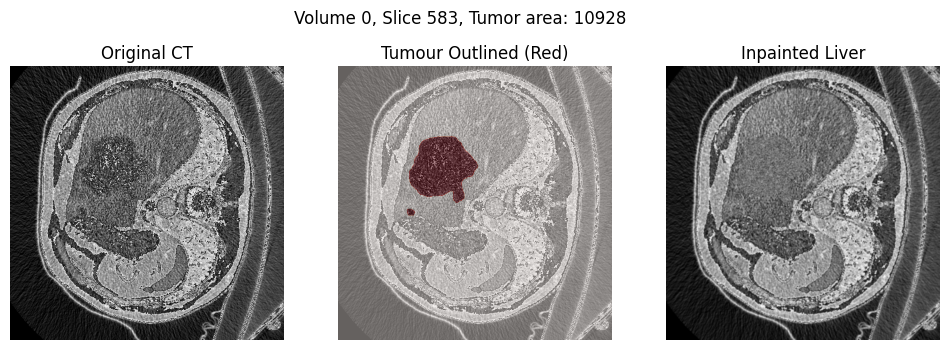

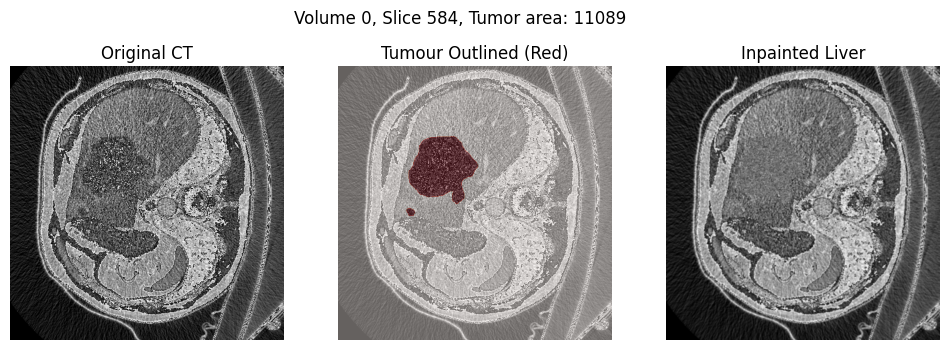

✅ Saved ct_100_inpainted.npz for volume-100.nii
✅ Saved ct_101_inpainted.npz for volume-101.nii
✅ Saved ct_102_inpainted.npz for volume-102.nii
✅ Saved ct_103_inpainted.npz for volume-103.nii
✅ Saved ct_104_inpainted.npz for volume-104.nii
✅ Saved ct_105_inpainted.npz for volume-105.nii
✅ Saved ct_106_inpainted.npz for volume-106.nii
✅ Saved ct_107_inpainted.npz for volume-107.nii
✅ Saved ct_108_inpainted.npz for volume-108.nii
✅ Saved ct_109_inpainted.npz for volume-109.nii
✅ Saved ct_110_inpainted.npz for volume-110.nii
✅ Saved ct_111_inpainted.npz for volume-111.nii
✅ Saved ct_112_inpainted.npz for volume-112.nii
✅ Saved ct_113_inpainted.npz for volume-113.nii
✅ Saved ct_114_inpainted.npz for volume-114.nii
✅ Saved ct_115_inpainted.npz for volume-115.nii
✅ Saved ct_116_inpainted.npz for volume-116.nii
✅ Saved ct_117_inpainted.npz for volume-117.nii
✅ Saved ct_118_inpainted.npz for volume-118.nii
✅ Saved ct_119_inpainted.npz for volume-119.nii
✅ Saved ct_120_inpainted.npz for volume-

In [13]:
# Cell 2: NCG Module (Liver-Aware Inpainting, Disk-Efficient, Tumor-Forced Large Tumor Visualization)
import os, random, gc, re
import numpy as np
import cv2
import matplotlib.pyplot as plt

def show_triplet(original, mask, inpainted, title=""):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original CT")
    axs[1].imshow(original, cmap='gray')
    axs[1].imshow(mask * 255, cmap='Reds', alpha=0.4)
    axs[1].set_title("Tumour Outlined (Red)")
    axs[2].imshow(inpainted, cmap='gray')
    axs[2].set_title("Inpainted Liver")
    for a in axs:
        a.axis('off')
    plt.suptitle(title)
    plt.show()

def liver_aware_inpaint(ct_slice, liver_mask, tumor_mask):
    filled = ct_slice.copy()
    healthy_liver_pixels = ct_slice[(liver_mask == 1) & (tumor_mask == 0)]
    coords = np.argwhere(tumor_mask == 1)

    if len(healthy_liver_pixels) == 0:
        return filled  # fallback

    for y, x in coords:
        filled[y, x] = np.random.choice(healthy_liver_pixels)

    # optional smoothing at boundary
    boundary = cv2.dilate(tumor_mask, np.ones((3, 3), np.uint8)) - tumor_mask
    filled[boundary > 0] = 0.6 * filled[boundary > 0] + 0.4 * ct_slice[boundary > 0]
    filled = cv2.GaussianBlur(filled, (3, 3), 0)
    return filled

def digits_of(s):
    """Extracts numeric part from filename (used for consistent naming)."""
    m = re.findall(r"\d+", str(s))
    return m[-1] if m else "unknown"

# --- Setup Paths ---
output_folder = "Training_datasets/inpainted_cts_slices"
os.makedirs(output_folder, exist_ok=True)

# --- Visualization Parameters ---
max_vis = 4
vis_examples = 0

# Process volumes
for idx, (vol_path, seg_path) in enumerate(zip(vol_files[:40], seg_files[:40])):
    ct_vol = read_nii(vol_path)
    seg_vol = read_nii(seg_path)
    inpainted_vol = np.zeros_like(ct_vol)

    # Identify slices with tumor areas, sort by tumor size descending
    tumor_slices = [(i, (seg_vol[:, :, i] == 2).sum()) for i in range(ct_vol.shape[-1])]
    tumor_slices = sorted([t for t in tumor_slices if t[1] > 0], key=lambda x: -x[1])

    for i in range(ct_vol.shape[-1]):
        ct_slice = ct_vol[:, :, i].astype(np.uint8)
        liver_mask = (seg_vol[:, :, i] == 1).astype(np.uint8)
        tumor_mask = (seg_vol[:, :, i] == 2).astype(np.uint8)

        if tumor_mask.sum() > 0:
            inpainted_slice = liver_aware_inpaint(ct_slice, liver_mask, tumor_mask)

            # Force visualization for largest tumors
            if vis_examples < max_vis and any(i == t[0] for t in tumor_slices[:max_vis]):
                show_triplet(ct_slice, tumor_mask, inpainted_slice,
                             title=f"Volume {idx}, Slice {i}, Tumor area: {tumor_mask.sum()}")
                vis_examples += 1
        else:
            inpainted_slice = ct_slice

        inpainted_vol[:, :, i] = inpainted_slice

    # --- Naming fix: extract digits from CT filename ---
    vol_id = digits_of(os.path.basename(vol_path))
    save_name = f"ct_{vol_id}_inpainted.npz"
    save_path = os.path.join(output_folder, save_name)

    np.savez_compressed(save_path,
                        inpainted=inpainted_vol.astype(np.uint8),
                        shape=inpainted_vol.shape)

    print(f"✅ Saved {save_name} for {os.path.basename(vol_path)}")

    # Free memory
    del ct_vol, seg_vol, inpainted_vol
    gc.collect()

print("✅ Liver-aware inpainting complete. Files saved to:", output_folder)


## Segmentation Section(Attempted)

In [14]:
# # --- Full Streaming-Based 2.5D Liver Segmentation (Torch 2.6 Compatible, Dice+Focal Loss) ---

# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# import numpy as np, random, gc, os, nibabel as nib
# from tqdm import tqdm

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", device)

# # ---------------- Config ----------------
# BATCH_SIZE = 8
# PATCH_SIZE = 200
# EPOCHS_PER_CHUNK = 4
# TOTAL_PASSES = 5
# CHUNK_SIZE = 4
# VAL_RATIO = 0.2
# LR = 1e-4
# USE_2_5D = True     # use 3 slices as input
# SKIP_EMPTY_SLICES = True

# # ---------------- Dataset ----------------
# class SliceDataset(Dataset):
#     def __init__(self, ct_paths, seg_paths, patch_size=PATCH_SIZE,
#                  skip_empty_slices=True, augment=True, oversample=1, use_2_5D=True):
#         self.ct_paths = ct_paths
#         self.seg_paths = seg_paths
#         self.patch_size = patch_size
#         self.slice_map = []
#         self.augment = augment
#         self.oversample = oversample
#         self.use_2_5D = use_2_5D

#         for vol_idx, ct_path in enumerate(ct_paths):
#             ct_img = nib.load(ct_path)
#             seg_img = nib.load(seg_paths[vol_idx])
#             n_slices = ct_img.shape[-1]
#             for s in range(n_slices):
#                 mask_slice = np.asarray(seg_img.dataobj[..., s], dtype=np.uint8)
#                 if skip_empty_slices and not np.any(mask_slice == 1):
#                     continue
#                 self.slice_map.append((vol_idx, s))
#             del ct_img, seg_img

#         if oversample > 1:
#             liver_slices = [(vol_idx, s) for vol_idx, s in self.slice_map
#                             if np.any(np.asarray(nib.load(seg_paths[vol_idx]).dataobj[..., s], dtype=np.uint8) == 1)]
#             self.slice_map += liver_slices * (oversample - 1)

#     def __len__(self):
#         return len(self.slice_map)

#     def __getitem__(self, idx):
#         vol_idx, slice_idx = self.slice_map[idx]
#         ct_img = nib.load(self.ct_paths[vol_idx])
#         seg_img = nib.load(self.seg_paths[vol_idx])

#         # --- 2.5D context ---
#         if self.use_2_5D:
#             indices = [max(0, slice_idx - 1), slice_idx, min(ct_img.shape[-1] - 1, slice_idx + 1)]
#             ct_slice = np.stack([np.asarray(ct_img.dataobj[..., i], dtype=np.float32) for i in indices], axis=0)
#         else:
#             ct_slice = np.asarray(ct_img.dataobj[..., slice_idx], dtype=np.float32)[None, ...]
#         seg_slice = np.asarray(seg_img.dataobj[..., slice_idx], dtype=np.uint8)[None, ...]
#         del ct_img, seg_img

#         # --- normalize & clip ---
#         ct_slice = np.clip(ct_slice, -200, 250)
#         ct_std = ct_slice.std() if ct_slice.std() > 1e-6 else 1.0
#         ct_slice = (ct_slice - ct_slice.mean()) / ct_std
#         seg_slice = (seg_slice == 1).astype(np.float32)

#         # --- pad to patch size ---
#         _, H, W = ct_slice.shape
#         pad_h = max(0, PATCH_SIZE - H)
#         pad_w = max(0, PATCH_SIZE - W)
#         ct_slice = np.pad(ct_slice, ((0, 0), (pad_h // 2, pad_h - pad_h // 2),
#                                      (pad_w // 2, pad_w - pad_w // 2)), mode='constant')
#         seg_slice = np.pad(seg_slice, ((0, 0), (pad_h // 2, pad_h - pad_h // 2),
#                                        (pad_w // 2, pad_w - pad_w // 2)), mode='constant')

#         return torch.tensor(ct_slice, dtype=torch.float32), torch.tensor(seg_slice, dtype=torch.float32)

# # ---------------- Model ----------------
# class UNet2_5D(nn.Module):
#     def __init__(self, in_ch=3):
#         super().__init__()
#         def conv_block(in_c, out_c):
#             return nn.Sequential(
#                 nn.Conv2d(in_c, out_c, 3, padding=1),
#                 nn.BatchNorm2d(out_c),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_c, out_c, 3, padding=1),
#                 nn.BatchNorm2d(out_c),
#                 nn.ReLU(inplace=True)
#             )
#         self.enc1 = conv_block(in_ch, 16)
#         self.enc2 = conv_block(16, 32)
#         self.enc3 = conv_block(32, 64)
#         self.pool = nn.MaxPool2d(2)
#         self.up3 = nn.ConvTranspose2d(64, 32, 2, stride=2)
#         self.dec2 = conv_block(64, 32)
#         self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
#         self.dec1 = conv_block(32, 16)
#         self.final = nn.Conv2d(16, 1, 1)

#     def forward(self, x):
#         e1 = self.enc1(x)
#         e2 = self.enc2(self.pool(e1))
#         e3 = self.enc3(self.pool(e2))
#         d2 = self.up3(e3)
#         d2 = torch.cat([d2, e2], dim=1)
#         d2 = self.dec2(d2)
#         d1 = self.up2(d2)
#         d1 = torch.cat([d1, e1], dim=1)
#         out = self.dec1(d1)
#         return self.final(out)

# # ---------------- Loss ----------------
# class DiceFocalLoss(nn.Module):
#     def __init__(self, alpha=0.8, gamma=2):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.bce = nn.BCEWithLogitsLoss()

#     def forward(self, pred, target):
#         bce = self.bce(pred, target)
#         pred_prob = torch.sigmoid(pred)
#         intersection = (pred_prob * target).sum()
#         dice = (2 * intersection + 1e-6) / (pred_prob.sum() + target.sum() + 1e-6)
#         focal = -self.alpha * (1 - pred_prob) ** self.gamma * target * torch.log(pred_prob + 1e-6)
#         focal = focal.mean()
#         return 0.4 * bce + 0.3 * (1 - dice) + 0.3 * focal

# # ---------------- Metrics ----------------
# def eval_metrics(pred, target, thresh=0.5):
#     pred_bin = (torch.sigmoid(pred) > thresh).float()
#     intersection = (pred_bin * target).sum()
#     union = (pred_bin + target - pred_bin * target).sum()
#     dice = (2 * intersection) / (pred_bin.sum() + target.sum() + 1e-6)
#     iou = intersection / (union + 1e-6)
#     acc = (pred_bin == target).float().mean()
#     return dice.item(), iou.item(), acc.item()

# # ---------------- Training ----------------
# def train_liver_segmentation(vol_files, seg_files):
#     vol_files = vol_files[:40]
#     seg_files = seg_files[:40]

#     train_idx, val_idx = train_test_split(range(len(vol_files)), test_size=VAL_RATIO, random_state=42)
#     train_files = [vol_files[i] for i in train_idx]
#     train_labels = [seg_files[i] for i in train_idx]
#     val_files = [vol_files[i] for i in val_idx]
#     val_labels = [seg_files[i] for i in val_idx]

#     in_ch = 3 if USE_2_5D else 1
#     model = UNet2_5D(in_ch=in_ch).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=LR)
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_PER_CHUNK)
#     criterion = DiceFocalLoss()

#     best_dice = 0.0

#     for pass_num in range(TOTAL_PASSES):
#         print(f"\n=== Pass {pass_num+1}/{TOTAL_PASSES} ===")
#         perm = list(range(len(train_files)))
#         random.shuffle(perm)
#         shuffled_train_files = [train_files[i] for i in perm]
#         shuffled_train_labels = [train_labels[i] for i in perm]

#         for start in range(0, len(shuffled_train_files), CHUNK_SIZE):
#             end = min(start + CHUNK_SIZE, len(shuffled_train_files))
#             ct_chunk = shuffled_train_files[start:end]
#             seg_chunk = shuffled_train_labels[start:end]

#             dataset = SliceDataset(ct_chunk, seg_chunk, augment=True, oversample=3)
#             if len(dataset) == 0:
#                 continue

#             dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,
#                                     num_workers=0, pin_memory=(device == "cuda"))

#             for epoch in range(EPOCHS_PER_CHUNK):
#                 model.train()
#                 total_loss, steps = 0, 0
#                 for ct, mask in tqdm(dataloader, desc=f"Chunk {start//CHUNK_SIZE+1} | Epoch {epoch+1}", leave=False):
#                     ct, mask = ct.to(device), mask.to(device)
#                     optimizer.zero_grad()
#                     pred = model(ct)
#                     loss = criterion(pred, mask)
#                     loss.backward()
#                     optimizer.step()
#                     total_loss += loss.item()
#                     steps += 1
#                 scheduler.step()
#                 print(f"Chunk {start//CHUNK_SIZE+1} | Epoch {epoch+1} | Train Loss: {total_loss/steps:.4f}")

#             del dataloader, dataset
#             gc.collect()
#             torch.cuda.empty_cache()

#         # --- Validation after each pass ---
#         model.eval()
#         val_dataset = SliceDataset(val_files, val_labels, augment=False)
#         val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
#         dice_scores, iou_scores, acc_scores = [], [], []
#         with torch.no_grad():
#             for ct, mask in tqdm(val_loader, desc="Validation", leave=False):
#                 ct, mask = ct.to(device), mask.to(device)
#                 pred = model(ct)
#                 d, i, a = eval_metrics(pred, mask)
#                 dice_scores.append(d)
#                 iou_scores.append(i)
#                 acc_scores.append(a)
#         mean_dice = np.mean(dice_scores)
#         print(f"Pass {pass_num+1}: Val Dice {mean_dice:.4f} | IoU {np.mean(iou_scores):.4f} | Acc {np.mean(acc_scores):.4f}")

#         save_dir = "checkpoints"
#         os.makedirs(save_dir, exist_ok=True)
#         if mean_dice > best_dice:
#             best_dice = mean_dice
#             torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
#             print(f"💾 Saved best model with Dice: {best_dice:.4f}")
#         torch.save(model.state_dict(), os.path.join(save_dir, f"pass_{pass_num+1}_model.pth"))

#         del val_loader, val_dataset
#         gc.collect()
#         torch.cuda.empty_cache()

#     print("✅ Training Complete")

# # -----------------------------
# # Usage
# # -----------------------------
# train_liver_segmentation(vol_files, seg_files)


In [15]:
# # --- Slice-wise Inference on Representative Tumor Slices ---
# import os, torch, numpy as np, random, nibabel as nib, cv2, matplotlib.pyplot as plt

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = UNet2D(in_ch=1).to(device)
# model.load_state_dict(torch.load("checkpoints/best_model.pth", map_location=device))
# model.eval()

# # Folder containing volumes and masks
# data_folder = "/kaggle/input/dataset-1/media/nas/01_Datasets/CT/LITS/Training Batch 2"
# all_files = sorted(os.listdir(data_folder))

# # Separate volumes and masks
# vol_files = [os.path.join(data_folder, f) for f in all_files if "volume" in f.lower() and f.endswith(".nii")]
# seg_files = [os.path.join(data_folder, f) for f in all_files if "segmentation" in f.lower() and f.endswith(".nii")]

# # Utility to read NIfTI
# def read_nii(path):
#     return np.asarray(nib.load(path).dataobj, dtype=np.float32)

# # Find slices with non-empty tumor masks
# slices_to_show = []
# for v_path, s_path in zip(vol_files, seg_files):
#     mask_vol = read_nii(s_path)
#     tumor_slices = np.where(mask_vol.sum(axis=(0,1)) > 500)[0]  # choose slices with sizable tumor
#     if len(tumor_slices) > 0:
#         for sl in tumor_slices[:3]:  # max 3 slices per volume
#             slices_to_show.append((v_path, s_path, sl))
#     if len(slices_to_show) >= 3:  # total of 3 slices
#         break

# # Function to overlay contours
# def show_contour_comparison(ct_slice, gt_mask, pred_mask, title=""):
#     ct_slice_uint8 = cv2.normalize(ct_slice, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
#     gt_mask_bin = (gt_mask == 1).astype(np.uint8) * 255
#     pred_mask_bin = (pred_mask == 1).astype(np.uint8) * 255

#     ct_gt = cv2.cvtColor(ct_slice_uint8, cv2.COLOR_GRAY2BGR)
#     ct_pred = cv2.cvtColor(ct_slice_uint8, cv2.COLOR_GRAY2BGR)

#     contours_gt, _ = cv2.findContours(gt_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours_pred, _ = cv2.findContours(pred_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.drawContours(ct_gt, contours_gt, -1, (0,0,255), 2)
#     cv2.drawContours(ct_pred, contours_pred, -1, (0,0,255), 2)

#     fig, axs = plt.subplots(1, 2, figsize=(12,6))
#     axs[0].imshow(ct_gt[..., ::-1])
#     axs[0].set_title("Ground Truth Contours (Red)")
#     axs[1].imshow(ct_pred[..., ::-1])
#     axs[1].set_title("Predicted Contours (Red)")
#     for ax in axs: ax.axis('off')
#     plt.suptitle(title)
#     plt.show()

# # Run inference on chosen slices
# for v_path, s_path, sl_idx in slices_to_show:
#     ct_vol = read_nii(v_path)
#     seg_vol = read_nii(s_path)

#     slice_np = np.clip(ct_vol[:,:,sl_idx], -200, 250)
#     slice_np = (slice_np - slice_np.mean()) / (slice_np.std() + 1e-6)
#     slice_img = torch.tensor(slice_np[None,None,:,:], dtype=torch.float32).to(device)

#     with torch.no_grad():
#         pred_slice = (torch.sigmoid(model(slice_img)) > 0.5).cpu().numpy()[0,0].astype(np.uint8)

#     show_contour_comparison(ct_vol[:,:,sl_idx], (seg_vol[:,:,sl_idx]==1).astype(np.uint8), pred_slice,
#                             title=f"Volume: {os.path.basename(v_path)}, Slice {sl_idx}")


In [ ]:
# Cell 5: Prepare Volumes for MCS (Liver-Masked or Original Backup)
import numpy as np
import os

output_folder = "Training_datasets/mcs_input_volumes"
os.makedirs(output_folder, exist_ok=True)

# Only use first 2 volumes for now; remove [:2] for full dataset
for vol_idx, (vol_path, seg_path) in enumerate(zip(vol_files[:40], seg_files[:40])):
    ct_vol = read_nii(vol_path)
    seg_vol = read_nii(seg_path)

    # --------------------------
    # Option 1: Use liver-masked CT for MCS (recommended)
    # liver_mask = (seg_vol == 1).astype(np.uint8)
    # use_ct_for_mcs = ct_vol * liver_mask
    # --------------------------

    # --------------------------
    # Option 2: Use original CT for MCS (backup if segmentation fails)
    use_ct_for_mcs = ct_vol
    # --------------------------

    save_path = os.path.join(output_folder, os.path.basename(vol_path))
    save_nii(use_ct_for_mcs, save_path)
    print(f"Saved volume for MCS module: {save_path}")

    del ct_vol, seg_vol, use_ct_for_mcs


## Pairing the (Healthy, Unhealthy) CT Scans

In [ ]:
# --- Match inpainted volumes to original volumes ---
import re
import numpy as np
import nibabel as nib
from pathlib import Path

# --- Helper functions ---
def extract_num_id(name):
    """Extract numeric ID from filename stem, e.g. 'ct_034_inpainted' -> '34'"""
    stem = Path(name).stem.lower()
    nums = re.findall(r'\d+', stem)
    return nums[-1] if nums else None

def list_inpainted_npzs(path):
    """Return sorted list of .npz inpainted files"""
    return sorted([p for p in Path(path).glob("*.npz")])

def safe_load_nii(path):
    """Safe NIfTI loader to handle corrupt files gracefully"""
    try:
        return nib.load(str(path)).get_fdata()
    except Exception as e:
        print(f"Warning: could not load {path}: {e}")
        return np.zeros((256,256,1), dtype=np.float32)

# --- Define paths ---
INPAINTED_DIR = Path("Training_datasets/inpainted_cts_slices")
ORIG_CT_DIR = Path("Training_Batch2")
SEG_DIR = ORIG_CT_DIR  # if segmentations stored together

# --- Build file lists ---
ORIG_VOL_LIST = sorted(list(ORIG_CT_DIR.glob("*.nii*")))
SEG_VOL_LIST  = sorted(list(SEG_DIR.glob("*seg*.nii*")))

# --- Build numeric-ID maps ---
inpainted_list = list_inpainted_npzs(INPAINTED_DIR)
inpainted_num_map = {extract_num_id(p.stem): p for p in inpainted_list if extract_num_id(p.stem) is not None}
orig_num_map     = {extract_num_id(Path(p).stem): p for p in ORIG_VOL_LIST if extract_num_id(Path(p).stem) is not None}
seg_num_map      = {extract_num_id(Path(p).stem): p for p in SEG_VOL_LIST if extract_num_id(Path(p).stem) is not None}

print(f"Found {len(inpainted_num_map)} inpainted volumes with numeric IDs in {INPAINTED_DIR}")

# --- Match pairs ---
paired_volumes = []   # list of tuples: (inpainted_npz_path, original_vol_path, seg_path)
unmatched = []

for num_id, npz_path in inpainted_num_map.items():
    if num_id in orig_num_map:
        vol_path = orig_num_map[num_id]
        seg_path = seg_num_map.get(num_id, None)
        paired_volumes.append((npz_path, vol_path, seg_path))
    else:
        unmatched.append(npz_path)

print(f"Paired {len(paired_volumes)} inpainted → original volume(s).")
if unmatched:
    print("⚠️ Unmatched inpainted files (by numeric ID):")
    for u in unmatched[:10]:
        print("  -", u)
    if len(unmatched) > 10:
        print(f"  ... and {len(unmatched)-10} more")

if len(paired_volumes) == 0:
    raise RuntimeError("No paired inpainted volumes found. Check numeric IDs (e.g., ct_034_inpainted vs ct_034.nii.gz).")

# --- Build slice-level index list ---
slice_index_list = []
for npz_path, vol_path, seg_path in paired_volumes:
    try:
        with np.load(npz_path) as z:
            n_slices = z["inpainted"].shape[-1]
    except Exception:
        vol_arr = safe_load_nii(vol_path)
        n_slices = vol_arr.shape[-1]
    for s in range(n_slices):
        slice_index_list.append((str(npz_path), str(vol_path), str(seg_path) if seg_path else None, int(s)))

print(f"✅ Built slice index list with {len(slice_index_list)} total slices across {len(paired_volumes)} paired volumes.")


Found 40 inpainted volumes with numeric IDs in Training_datasets/inpainted_cts_slices
Paired 40 inpainted → original volume(s).
✅ Built slice index list with 21951 total slices across 40 paired volumes.


In [ ]:
!pip install seaborn

## Visualising the paired impainted and actual CT scan

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import nibabel as nib
from pathlib import Path

# Force resize shape (same as used in training)
FORCE_SIZE = (256, 256)

def preprocess_pb_feltucs(img, clip_min=-100, clip_max=300, out_size=(256,256), gamma=2.0):
    """
    Preprocess a single CT slice for visualization or model input.
    Matches the training preprocessing pipeline.
    """
    # 1️⃣ Clip Hounsfield Units
    img = np.clip(img, clip_min, clip_max)

    # 2️⃣ Normalize to [0,1]
    img = (img - clip_min) / (clip_max - clip_min)

    # 3️⃣ Gamma correction (for soft contrast)
    img = np.power(img, gamma)

    # 4️⃣ Scale to [0,255]
    img = (img * 255).astype(np.uint8)

    # 5️⃣ Resize to FORCE_SIZE
    img = cv2.resize(img, out_size, interpolation=cv2.INTER_LINEAR)

    # 6️⃣ Normalize back to [0,1] for plotting
    return img.astype(np.float32) / 255.0

# Assume these are defined from your pairing code
# If not, uncomment/adjust:
# paired_volumes = [...]  # From your pairing
# FORCE_SIZE = (256, 256)
# def preprocess_pb_feltucs(...):  # Your preprocess function

if len(paired_volumes) == 0:
    print("No paired volumes found—run pairing first!")
else:
    # Load first pair
    npz_path, orig_path, seg_path = paired_volumes[0]
    print(f"Visualizing pair: {Path(npz_path).name} ↔ {Path(orig_path).name}")
    
    # Find a tumor slice (or default to 0)
    tumor_slice_idx = 0
    if seg_path:
        seg_vol = nib.load(seg_path).get_fdata()
        tumor_slices = np.where([np.any(seg_vol[..., s] == 2) for s in range(seg_vol.shape[-1])])[0]
        if len(tumor_slices) > 0:
            tumor_slice_idx = tumor_slices[0]  # First tumor slice
            print(f"Using tumor slice {tumor_slice_idx} (out of {len(tumor_slices)} tumor slices)")
    
    # Load slices
    with np.load(npz_path) as z:
        healthy_raw = z["inpainted"][..., tumor_slice_idx]
    orig_vol = nib.load(orig_path).get_fdata()
    target_raw = orig_vol[..., tumor_slice_idx]
    if seg_path:
        seg_slice = seg_vol[..., tumor_slice_idx]
        tumor_mask = (seg_slice == 2).astype(np.float32)
    else:
        tumor_mask = np.zeros_like(target_raw)  # Fallback no mask
    
    # Preprocess
    healthy_norm = preprocess_pb_feltucs(healthy_raw, clip_min=-100, clip_max=300, out_size=FORCE_SIZE)
    target_norm = preprocess_pb_feltucs(target_raw, clip_min=-100, clip_max=300, out_size=FORCE_SIZE)
    tumor_mask_r = cv2.resize(tumor_mask.astype(np.uint8), (FORCE_SIZE[1], FORCE_SIZE[0]), interpolation=cv2.INTER_NEAREST).astype(np.float32)
    
    # Density stats
    tumor_region_target = target_norm[tumor_mask_r > 0]
    tumor_region_healthy = healthy_norm[tumor_mask_r > 0]
    print(f"Tumor region (target): mean={tumor_region_target.mean():.3f} ± {tumor_region_target.std():.3f} (n={len(tumor_region_target)})")
    print(f"Tumor region (healthy): mean={tumor_region_healthy.mean():.3f} ± {tumor_region_healthy.std():.3f}")
    print(f"Density diff: {tumor_region_target.mean() - tumor_region_healthy.mean():.3f} (positive = brighter tumor)")
    
    # Plotting function for contrast
    def viz_slice(img, title, ax, vmin=-0.2, vmax=0.8):  # Liver window approx
        ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.axis('off')
    
    # Side-by-side plot
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: Full range (may look "black")
    viz_slice(healthy_norm, 'Healthy (Inpainted) - Full Range', axs[0,0])
    viz_slice(target_norm, 'Target (Original + Tumor) - Full Range', axs[0,1])
    axs[0,2].imshow(tumor_mask_r, cmap='Reds'); axs[0,2].set_title('Tumor Mask Overlay')
    
    # Row 2: Windowed + overlay + diff
    viz_slice(healthy_norm, 'Healthy - Windowed', axs[1,0])
    axs[1,1].imshow(target_norm, cmap='gray', vmin=-0.2, vmax=0.8)
    axs[1,1].imshow(tumor_mask_r, cmap='Reds', alpha=0.5)  # Overlay on target
    axs[1,1].set_title('Target + Tumor Overlay (Windowed)')
    diff = target_norm - healthy_norm
    im = axs[1,2].imshow(diff, cmap='RdBu', vmin=-0.1, vmax=0.1)
    axs[1,2].set_title('Difference (Tumor Insertion)')
    plt.colorbar(im, ax=axs[1,2])
    
    plt.tight_layout()
    plt.savefig('paired_slices_viz.png', dpi=150, bbox_inches='tight')
    plt.show()
    

Visualizing pair: ct_100_inpainted.npz ↔ volume-100.nii
Using tumor slice 406 (out of 235 tumor slices)
Tumor region (target): mean=0.170 ± 0.041 (n=4)
Tumor region (healthy): mean=0.267 ± 0.032
Density diff: -0.097 (positive = brighter tumor)


In [ ]:
!rm -rf ~/.cache/* ~/.ipython/profile_default/history.sqlite /tmp/*


## Diffusion Model Section

In [31]:
# Cell: Enhanced Chunked Conditional Diffusion Training with Plotting
# (Merged fixes: whole-image reconstruction + tumour insertion + memory/visualization safety)

import os
import re
import math
import random
import glob
import gc
import warnings
from pathlib import Path
from tqdm import tqdm
import numpy as np
import nibabel as nib
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from copy import deepcopy
from einops import rearrange
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import Normalize

warnings.filterwarnings("ignore", message=r"pixdim\[0\] \(qfac\) should be 1 \(default\) or -1; setting qfac to 1")

# ==================== USER CONFIG ====================
INPAINTED_DIR = Path("Training_datasets/inpainted_cts_slices")
ORIG_CT_DIR = Path("Training_Batch2")
SEG_DIR = ORIG_CT_DIR
FORCE_SIZE = (256, 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparams (tune for your GPU)
LR = 1e-4
BATCH_SIZE = 4                 # safer default
CHUNK_SIZE = 4
PASSES = 5
EPOCHS_PER_CHUNK = 3
TIMESTEPS = 1000
COND_CHANNELS = 2

# Model capacity (reduce for debug, increase later)
BASE_CH = 64
CH_MULT = (1, 2, 4)
NUM_RES_BLOCKS = 2
TIME_DIM = 256

# Flags and misc
USE_EMA = True
EMA_DECAY = 0.9999
EMA_UPDATE_EVERY = 10
USE_V_PARAM = True
PERCEPTUAL_WEIGHT = 0.0
GUIDANCE_SCALE = 2.0
UNCOND_DROP_PROB = 0.2
MIXED_PRECISION = True
GRADIENT_ACCUMULATION_STEPS = 2

USE_AUGMENTATION = True
AUG_PROB = 0.5

# Visualization / debug
PLOT_DEBUG = False             # set True for single-sample debugging (writes debug_sample_*.png)
VIZ_SAMPLE_TIMESTEPS = 50      # cheap sampling for mid-pass visuals

CHECKPOINT_DIR = Path("checkpoints/diffusion_enhanced")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
VIS_DIR = Path("visualizations")
VIS_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(f"Device: {DEVICE}")
if DEVICE.type == "cuda":
    try:
        print(f"Current device index: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    except Exception:
        pass
print(f"Mixed Precision: {MIXED_PRECISION}")
print(f"EMA Enabled: {USE_EMA}")
print(f"V-Parameterization: {USE_V_PARAM}")

# ==================== HELPERS ====================
_digits = re.compile(r"\d+")
def digits_of(s):
    m = _digits.findall(str(s))
    return m[-1] if m else None

def list_inpainted_npzs(path):
    return sorted([p for p in Path(path).glob("*.npz")])

def find_matching_volume(npz_name, orig_dir, seg_dir):
    d = digits_of(npz_name)
    if d is None:
        return None, None
    patterns = [f"*{d}*.nii", f"*{d}*.nii.gz"]
    found_ct = None
    for pat in patterns:
        hits = list(Path(orig_dir).glob(pat))
        if hits:
            found_ct = hits[0]
            break
    found_seg = None
    for pat in patterns:
        hits = list(Path(seg_dir).glob(pat))
        if hits:
            for h in hits:
                if "seg" in h.name.lower() or "segment" in h.name.lower():
                    found_seg = h
                    break
            if found_seg is None:
                found_seg = hits[0]
            break
    return (found_ct, found_seg)

# ==================== PREPROCESSING ====================
def preprocess_pb_feltucs(slice_np, clip_min=-100, clip_max=300, out_size=(256,256)):
    s = np.clip(slice_np, clip_min, clip_max).astype(np.float32)
    s = (s - clip_min) / (clip_max - clip_min)
    s = s * 2.0 - 1.0
    h, w = s.shape
    if (h, w) != out_size:
        s = cv2.resize(s, (out_size[1], out_size[0]), interpolation=cv2.INTER_LINEAR)
    return s.astype(np.float32)

# ==================== NOISE SCHEDULE & UTILS ====================
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0.0001, 0.9999)

betas = torch.tensor(cosine_beta_schedule(TIMESTEPS, s=0.008), dtype=torch.float32).to(DEVICE)
alphas = 1.0 - betas
alpha_cum = torch.cumprod(alphas, dim=0)
sqrt_alpha_cum = torch.sqrt(alpha_cum)
sqrt_one_minus_alpha_cum = torch.sqrt(1.0 - alpha_cum)

def q_sample(x0, noise, t):
    a = sqrt_alpha_cum[t].view(-1,1,1,1)
    b = sqrt_one_minus_alpha_cum[t].view(-1,1,1,1)
    return a * x0 + b * noise

def get_v_target(x0, noise, t):
    a = sqrt_alpha_cum[t].view(-1,1,1,1)
    b = sqrt_one_minus_alpha_cum[t].view(-1,1,1,1)
    return a * noise - b * x0

def predict_x0_from_v(xt, v_pred, t):
    a = sqrt_alpha_cum[t].view(-1,1,1,1)
    b = sqrt_one_minus_alpha_cum[t].view(-1,1,1,1)
    return a * xt - b * v_pred

# ==================== EMA WRAPPER ====================
class EMA:
    def __init__(self, model, decay=0.9999, update_every=10):
        super().__init__()
        self.model = model
        self.decay = decay
        self.update_every = update_every
        self.step = 0
        self.shadow = deepcopy(model)
        self.shadow.eval()
        for p in self.shadow.parameters():
            p.requires_grad = False

    def update(self):
        self.step += 1
        if self.step % self.update_every != 0:
            return
        with torch.no_grad():
            model_params = dict(self.model.named_parameters())
            shadow_params = dict(self.shadow.named_parameters())
            for name in model_params.keys():
                shadow_params[name].data.mul_(self.decay).add_(model_params[name].data, alpha=1 - self.decay)

    def apply_shadow(self):
        return self.shadow

    def state_dict(self):
        return {'shadow': self.shadow.state_dict(), 'step': self.step, 'decay': self.decay}

    def load_state_dict(self, state_dict):
        self.shadow.load_state_dict(state_dict['shadow'])
        self.step = state_dict['step']
        self.decay = state_dict['decay']

# ==================== MODEL (UNET) ====================
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        self.norm1 = nn.GroupNorm(8, max(1, in_ch))
        self.norm2 = nn.GroupNorm(8, max(1, out_ch))
        self.act = nn.SiLU()
        self.dropout = nn.Dropout(dropout)
        if in_ch != out_ch:
            self.residual_conv = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x, t_emb):
        h = self.norm1(x)
        h = self.act(h)
        h = self.conv1(h)
        t = self.time_mlp(t_emb)
        h = h + t[:, :, None, None]
        h = self.norm2(h)
        h = self.act(h)
        h = self.dropout(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        assert channels % num_heads == 0
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)
        q, k, v = rearrange(qkv, 'b (three h d) x y -> three b h (x y) d', three=3, h=self.num_heads)
        attn = torch.einsum('bhid,bhjd->bhij', q, k) * (C // self.num_heads) ** -0.5
        attn = F.softmax(attn, dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=H, y=W)
        out = self.proj(out)
        return out + x

class EnhancedUNet(nn.Module):
    def __init__(self, in_ch=1, cond_ch=2, base_ch=64, ch_mult=(1,2,4), num_res_blocks=2, time_dim=256, dropout=0.1, use_attention=True):
        super().__init__()
        self.in_ch = in_ch
        self.cond_ch = cond_ch
        self.time_mlp = nn.Sequential(SinusoidalPosEmb(time_dim), nn.Linear(time_dim, time_dim*4), nn.SiLU(), nn.Linear(time_dim*4, time_dim))
        self.input_conv = nn.Conv2d(in_ch + cond_ch, base_ch, 3, padding=1)
        self.downs = nn.ModuleList()
        chs = [base_ch]
        now_ch = base_ch
        for i, mult in enumerate(ch_mult):
            out_ch = base_ch * mult
            for _ in range(num_res_blocks):
                self.downs.append(ResBlock(now_ch, out_ch, time_dim, dropout))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downs.append(nn.Conv2d(now_ch, now_ch, 3, stride=2, padding=1))
                chs.append(now_ch)
        self.mid = nn.ModuleList([ResBlock(now_ch, now_ch, time_dim, dropout),
                                  AttentionBlock(now_ch) if use_attention else nn.Identity(),
                                  ResBlock(now_ch, now_ch, time_dim, dropout)])
        self.ups = nn.ModuleList()
        for i, mult in enumerate(reversed(ch_mult)):
            out_ch = base_ch * mult
            for j in range(num_res_blocks + 1):
                self.ups.append(ResBlock(now_ch + chs.pop(), out_ch, time_dim, dropout))
                now_ch = out_ch
            if i != len(ch_mult) - 1:
                self.ups.append(nn.ConvTranspose2d(now_ch, now_ch, 4, 2, 1))
        self.out_norm = nn.GroupNorm(8, base_ch)
        self.out_conv = nn.Conv2d(base_ch, in_ch, 3, padding=1)

    def forward(self, x, cond, t, drop_cond=False):
        if drop_cond:
            cond = torch.zeros_like(cond)
        t_emb = self.time_mlp(t)
        h = torch.cat([x, cond], dim=1)
        h = self.input_conv(h)
        hs = [h]
        for layer in self.downs:
            if isinstance(layer, ResBlock):
                h = layer(h, t_emb)
            else:
                h = layer(h)
            hs.append(h)
        for layer in self.mid:
            if isinstance(layer, ResBlock):
                h = layer(h, t_emb)
            else:
                h = layer(h)
        for layer in self.ups:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
                h = layer(h, t_emb)
            else:
                h = layer(h)
        h = self.out_norm(h)
        h = F.silu(h)
        h = self.out_conv(h)
        return h

# ==================== AUGMENTATION ====================
def augment_medical(img, mask, p=0.5):
    if random.random() > p:
        return img, mask
    if random.random() < 0.5:
        img = torch.flip(img, dims=[-1])
        mask = torch.flip(mask, dims=[-1])
    if random.random() < 0.3:
        angle = random.uniform(-10, 10)
        img = torch.from_numpy(cv2.warpAffine(img.numpy()[0], cv2.getRotationMatrix2D((img.shape[-1]//2, img.shape[-2]//2), angle, 1.0), (img.shape[-1], img.shape[-2]), flags=cv2.INTER_LINEAR)).unsqueeze(0)
        mask = torch.from_numpy(cv2.warpAffine(mask.numpy()[0], cv2.getRotationMatrix2D((mask.shape[-1]//2, mask.shape[-2]//2), angle, 1.0), (mask.shape[-1], mask.shape[-2]), flags=cv2.INTER_NEAREST)).unsqueeze(0)
    return img, mask

# ==================== PERCEPTUAL LOSS ====================
try:
    from torchvision import models
    vgg = models.vgg19(pretrained=True).features[:16].eval().to(DEVICE)
    for p in vgg.parameters():
        p.requires_grad = False
    def perceptual_loss_fn(pred, target):
        p = torch.clamp((pred + 1.0) / 2.0, 0, 1).repeat(1, 3, 1, 1)
        t = torch.clamp((target + 1.0) / 2.0, 0, 1).repeat(1, 3, 1, 1)
        return F.mse_loss(vgg(p), vgg(t))
except Exception as e:
    def perceptual_loss_fn(pred, target):
        return torch.tensor(0.0, device=DEVICE)

# ==================== DATASET ====================
class ChunkSliceDataset(Dataset):
    def __init__(self, entries, preprocess_fn, clip_min=-100, clip_max=300, force_size=(256,256), augment=False, aug_prob=0.3):
        self.entries = entries
        self.preprocess = preprocess_fn
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.force_size = force_size
        self.augment = augment
        self.aug_prob = aug_prob
        volume_to_slices = defaultdict(list)
        for entry in self.entries:
            vol_key = (entry[0], entry[1], entry[2])
            volume_to_slices[vol_key].append(entry[3])
        filtered = []
        for vol_key, slices_list in volume_to_slices.items():
            npz_path, orig_path, seg_path = vol_key
            try:
                with np.load(npz_path) as z:
                    n_npz = z["inpainted"].shape[-1]
            except Exception:
                n_npz = None
            try:
                orig_nii = nib.load(orig_path)
                n_orig = orig_nii.shape[-1]
            except Exception:
                n_orig = None
            try:
                seg_vol = nib.load(seg_path).get_fdata()
                n_seg = seg_vol.shape[-1]
                tumor_slices = []
                for s in set(slices_list):
                    if s < n_seg and (seg_vol[..., s] == 2).any():
                        tumor_slices.append(s)
            except Exception:
                n_seg = None
                tumor_slices = [s for s in set(slices_list) if s >= 0]
            ns = [n for n in [n_npz, n_orig, n_seg] if n is not None]
            n = min(ns) if ns else max(1, max(set(slices_list) or [0]))
            valid_tumor_slices = [s for s in tumor_slices if s < n]
            for s in valid_tumor_slices:
                filtered.append((npz_path, orig_path, seg_path, s))
        self.slice_entries = filtered
        if len(self.slice_entries) == 0:
            raise RuntimeError("No tumor slices found!")
        print(f"Dataset filtered: {len(filtered)} tumor slices out of {len(entries)} total")

    def __len__(self):
        return len(self.slice_entries)

    def __getitem__(self, idx):
        npz_path, orig_path, seg_path, s = self.slice_entries[idx]
        with np.load(npz_path) as z:
            healthy_slice = z["inpainted"][..., s].astype(np.float32)
        orig_vol = nib.load(orig_path).get_fdata().astype(np.float32)
        seg_vol = nib.load(seg_path).get_fdata().astype(np.int16)
        seg_slice = seg_vol[..., s]

        # Separate tumor & liver masks
        tumor_mask = (seg_slice == 2).astype(np.float32)
        liver_mask = (seg_slice == 1).astype(np.float32)

        # Get full original CT
        orig_ct_slice = orig_vol[..., s].astype(np.float32)

        # Overlay tumor onto CT (preserve healthy intensity elsewhere)
        # Here, you can slightly amplify tumor brightness to make it distinct
        target_slice = orig_ct_slice.copy()
        # --- Intensity-match target to inpainted slice dynamically ---
        mu_in, sigma_in = np.mean(healthy_slice), np.std(healthy_slice)
        mu_tg, sigma_tg = np.mean(target_slice), np.std(target_slice)
        if sigma_tg > 1e-6:
            target_slice = (target_slice - mu_tg) / sigma_tg * sigma_in + mu_in
            target_slice = np.clip(target_slice, np.min(healthy_slice), np.max(healthy_slice))
        # -------------------------------------------------------------

        # Preprocess after intensity alignment
        healthy_pp = self.preprocess(healthy_slice, self.clip_min, self.clip_max, self.force_size)
        target_pp  = self.preprocess(target_slice, self.clip_min, self.clip_max, self.force_size)

        tumor_mask_r = cv2.resize(tumor_mask.astype(np.uint8), (self.force_size[1], self.force_size[0]), interpolation=cv2.INTER_NEAREST).astype(np.float32)
        liver_mask_r = cv2.resize(liver_mask.astype(np.uint8), (self.force_size[1], self.force_size[0]), interpolation=cv2.INTER_NEAREST).astype(np.float32)
        healthy_t = torch.from_numpy(healthy_pp).unsqueeze(0).float()
        target_t = torch.from_numpy(target_pp).unsqueeze(0).float()
        tumor_mask_t = torch.from_numpy(tumor_mask_r).unsqueeze(0).float()
        liver_mask_t = torch.from_numpy(liver_mask_r).unsqueeze(0).float()
        
        if self.augment:
            healthy_t, liver_mask_t = augment_medical(healthy_t, liver_mask_t, self.aug_prob)
            target_t, tumor_mask_t = augment_medical(target_t, tumor_mask_t, self.aug_prob)

        return healthy_t, target_t, tumor_mask_t, liver_mask_t

def build_slice_entries_for_pairs(pairs):
    entries = []
    for npz_path, orig_path, seg_path in pairs:
        try:
            with np.load(npz_path) as z:
                n = z["inpainted"].shape[-1]
        except Exception:
            n = nib.load(orig_path).shape[-1]
        for s in range(n):
            entries.append((npz_path, orig_path, seg_path, s))
    return entries

# ==================== METRICS ====================
def psnr(pred, target, data_range=2.0):
    mse = F.mse_loss(pred, target).item()
    if mse == 0:
        return float("inf")
    return 10 * math.log10((data_range**2) / mse)

def ssim_loss(pred, target, window_size=11):
    c1 = (0.01 * 2) ** 2
    c2 = (0.03 * 2) ** 2
    mu1 = F.avg_pool2d(pred, window_size, 1, window_size//2)
    mu2 = F.avg_pool2d(target, window_size, 1, window_size//2)
    ##Local means(luminance)
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    ##Local variances and covariance (contrast and structure)
    sigma1_sq = F.avg_pool2d(pred * pred, window_size, 1, window_size//2) - mu1_sq
    sigma2_sq = F.avg_pool2d(target * target, window_size, 1, window_size//2) - mu2_sq
    sigma12 = F.avg_pool2d(pred * target, window_size, 1, window_size//2) - mu1_mu2
    ##Luminance similarity + constrast similarity(structural similarity through covariance)
    ssim_map = ((2 * mu1_mu2 + c1) * (2 * sigma12 + c2)) / ((mu1_sq + mu2_sq + c1) * (sigma1_sq + sigma2_sq + c2))
    return 1 - ssim_map.mean()

# ==================== INFERENCE SAMPLER ====================
def ddpm_sample(model, cond, shape, timesteps=1000, guidance_scale=2.0, device=DEVICE):
    model.eval()
    B = cond.shape[0]
    x = torch.randn(shape, device=device)
    with torch.no_grad():
        for t_idx in reversed(range(timesteps)):
            t = torch.full((B,), t_idx, device=device, dtype=torch.long)
            pred_cond = model(x, cond, t, drop_cond=False)
            pred_uncond = model(x, cond, t, drop_cond=True)
            pred_noise = pred_uncond + guidance_scale * (pred_cond - pred_uncond)
            alpha = alphas[t][:, None, None, None]
            alpha_cum_t = alpha_cum[t][:, None, None, None]
            beta = betas[t][:, None, None, None]
            if t_idx > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            if USE_V_PARAM:
                x0 = predict_x0_from_v(x, pred_noise, t)
            else:
                x0 = (x - sqrt_one_minus_alpha_cum[t][:, None, None, None] * pred_noise) / sqrt_alpha_cum[t][:, None, None, None]
            x0 = torch.clamp(x0, -1.0, 1.0)
            if t_idx > 0:
                alpha_cum_prev = alpha_cum[t_idx - 1].expand(B).to(device)
                eta = 1.0
                sigma = torch.sqrt(eta * beta * (1 - alpha_cum_prev) / (1 - alpha_cum_t))
                x = (
                    torch.sqrt(alpha_cum_prev)[:, None, None, None] * x0
                    + torch.sqrt(1 - alpha_cum_prev - sigma**2)[:, None, None, None] * pred_noise
                    + sigma[:, None, None, None] * noise
                )
            else:
                x = x0

    return torch.clamp(x, -1.0, 1.0)

# ==================== VISUALIZATION ====================
def visualize_sample(eval_model, healthy_t, target_t, tumor_mask_t, liver_mask_t, pass_n, stage="mid"):
    B = 1
    # For visuals, prefer inference-time conditioning: use healthy_t as condition (if available)
    cond = torch.cat([healthy_t[:1].to(DEVICE), liver_mask_t[:1].to(DEVICE)], dim=1)
    shape = (B, 1, FORCE_SIZE[0], FORCE_SIZE[1])
    # cheap sample for visualization
    cond = cond.float()

    # Remove *only* trailing singleton dims (not batch/channel)
    while cond.dim() > 4:
        cond = cond.squeeze(-1)

    if cond.dim() == 3:  # (C, H, W)
        cond = cond.unsqueeze(0)
    elif cond.dim() == 2:  # (H, W)
        cond = cond.unsqueeze(0).unsqueeze(0)

    shape = (1, 1, *FORCE_SIZE)
  # ensure shape consistency
    generated = ddpm_sample(eval_model, cond, shape, timesteps=VIZ_SAMPLE_TIMESTEPS, guidance_scale=GUIDANCE_SCALE, device=DEVICE)

    # blend: keep non-tumour area from healthy cond and tumour area from generated
    # Full-slice visualization (no mask blending)
    blended = generated[0:1,0].cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(healthy_t[0,0].cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    axs[0].set_title('Condition (Healthy Slice)')
    axs[1].imshow(target_t[0,0].cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    axs[1].set_title('Target (Ground Truth Full CT)')
    axs[2].imshow(blended[0], cmap='gray', vmin=-1, vmax=1)
    axs[2].set_title('Generated (Full CT Reconstruction)')
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.savefig(VIS_DIR / f'pass_{pass_n+1}_{stage}_sample_fullCT.png', dpi=150, bbox_inches='tight')
    plt.close()

    del generated
    torch.cuda.empty_cache()
    print(f"Visualization saved: pass_{pass_n+1}_{stage}_sample.png")

# ==================== TRAINING SETUP ====================
print("\n=== Building Model ===")
model = EnhancedUNet(in_ch=1, cond_ch=COND_CHANNELS, base_ch=BASE_CH, ch_mult=CH_MULT, num_res_blocks=NUM_RES_BLOCKS, time_dim=TIME_DIM, dropout=0.1, use_attention=True).to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
if USE_EMA:
    ema = EMA(model, decay=EMA_DECAY, update_every=EMA_UPDATE_EVERY)
optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=max(1, PASSES * EPOCHS_PER_CHUNK * 50), eta_min=LR * 0.01)
if MIXED_PRECISION:
    scaler = torch.cuda.amp.GradScaler()
best_val_loss = float("inf")
global_step = 0

# logs
train_losses_per_epoch = []
val_losses_per_epoch = []
val_psnrs_per_epoch = []
val_tumor_mses_per_epoch = []
val_ssims_per_epoch = []
lrs_per_epoch = []

# checkpoint resume (kept as before)
last_ckpt = CHECKPOINT_DIR / "last_model.pth"
start_pass = 1
load_success = False
if last_ckpt.exists():
    try:
        checkpoint = torch.load(last_ckpt, map_location=DEVICE)
        model_state = model.state_dict()
        ckpt_state = checkpoint['model']
        if set(model_state.keys()) == set(ckpt_state.keys()):
            shape_mismatch = False
            for key in list(model_state.keys())[:5]:
                if model_state[key].shape != ckpt_state[key].shape:
                    shape_mismatch = True; break
            if not shape_mismatch:
                model.load_state_dict(ckpt_state)
                optim.load_state_dict(checkpoint['optimizer'])
                scheduler.load_state_dict(checkpoint['scheduler'])
                best_val_loss = checkpoint.get('val_loss', float("inf"))
                global_step = checkpoint.get('global_step', 0)
                if USE_EMA and 'ema' in checkpoint:
                    ema.load_state_dict(checkpoint['ema'])
                if MIXED_PRECISION and 'scaler' in checkpoint:
                    scaler.load_state_dict(checkpoint['scaler'])
                start_pass = checkpoint.get('pass', 1)
                load_success = True
                print(f"✅ Loaded checkpoint from pass {start_pass}")
            else:
                print("⚠️ Checkpoint shape mismatch, starting fresh")
        else:
            print("⚠️ Checkpoint key mismatch, starting fresh")
    except Exception as e:
        print(f"⚠️ Checkpoint load failed: {e}")
else:
    print("No checkpoint found - starting fresh")

if not load_success:
    print("Starting fresh training")

# ==================== DATA PREPARATION ====================
print("\n=== Preparing Data ===")
all_npzs = list_inpainted_npzs(INPAINTED_DIR)
all_pairs = []
for npz in all_npzs:
    orig, seg = find_matching_volume(npz.name, ORIG_CT_DIR, SEG_DIR)
    if orig and seg:
        all_pairs.append((npz, orig, seg))
split_idx = int(len(all_pairs) * 0.8)
train_pairs = all_pairs[:split_idx]
val_pairs = all_pairs[split_idx:]
train_all_entries = build_slice_entries_for_pairs(train_pairs)
val_all_entries = build_slice_entries_for_pairs(val_pairs)
print(f"Train slices: {len(train_all_entries)}")
print(f"Val slices: {len(val_all_entries)}")

# fixed val sample for visualization
if len(val_pairs) > 0:
    val_sample_entries = build_slice_entries_for_pairs(val_pairs[:1])
    val_sample_dataset = ChunkSliceDataset(val_sample_entries, preprocess_pb_feltucs, clip_min=-100, clip_max=300, force_size=FORCE_SIZE, augment=False)
    val_sample_loader = DataLoader(val_sample_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    healthy_sample, target_sample, tumor_sample, liver_sample = next(iter(val_sample_loader))
    healthy_sample, target_sample, tumor_sample, liver_sample = [t.to(DEVICE) for t in [healthy_sample, target_sample, tumor_sample, liver_sample]]
else:
    healthy_sample = target_sample = tumor_sample = liver_sample = None

# ==================== TRAINING LOOP ====================
# --- Checkpoint setup (resume if available) ---
CKPT_PATH = "checkpoints/latest_ddpm.pt"
os.makedirs("checkpoints", exist_ok=True)

start_epoch = 0
if os.path.exists(CKPT_PATH):
    print(f"🔄 Found existing checkpoint at {CKPT_PATH}, resuming...")
    ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    optim.load_state_dict(ckpt["optimizer"])
    start_epoch = ckpt.get("epoch", 0) + 1
    print(f"Resuming from epoch {start_epoch}")
else:
    print("🆕 No checkpoint found, starting from scratch.")

print("\n=== Starting Training ===")
epoch_counter = 0
for pass_n in range(start_pass, PASSES):
    print(f"\n{'='*40}\nPASS {pass_n+1}/{PASSES}\n{'='*40}")
    random.shuffle(train_pairs)
    num_chunks = max(1, math.ceil(len(train_pairs) / CHUNK_SIZE))
    mid_chunk_idx = num_chunks // 2
    chunk_counter = 0
    for chunk_start in range(0, len(train_pairs), CHUNK_SIZE):
        chunk_pairs = train_pairs[chunk_start:chunk_start+CHUNK_SIZE]
        chunk_entries = build_slice_entries_for_pairs(chunk_pairs)
        try:
            dataset = ChunkSliceDataset(chunk_entries, preprocess_pb_feltucs, clip_min=-100, clip_max=300, force_size=FORCE_SIZE, augment=USE_AUGMENTATION, aug_prob=AUG_PROB)
        except RuntimeError as e:
            print(f"Skipping chunk: {e}"); continue
        dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
        for epoch in range(EPOCHS_PER_CHUNK):
            model.train()
            running_loss = 0.0; steps = 0
            optim.zero_grad(); epoch_counter += 1
            pbar = tqdm(dataloader, desc=f"P{pass_n+1} C{chunk_counter+1} E{epoch+1}", leave=False)
            for batch_idx, (healthy_t, target_t, tumor_mask_t, liver_mask_t) in enumerate(pbar):
                healthy_t = healthy_t.to(DEVICE); target_t = target_t.to(DEVICE)
                tumor_mask_t = tumor_mask_t.to(DEVICE); liver_mask_t = liver_mask_t.to(DEVICE)
                B = healthy_t.shape[0]
                t = torch.randint(0, TIMESTEPS, (B,), device=DEVICE).long()
                noise = torch.randn_like(target_t)
                x_t = q_sample(target_t, noise, t)

                # --- Conditioning robustness (simulate inference) ---
                P_REPLACE_WITH_TARGET = 0.12
                P_DROP_LIVER_MASK = 0.12
                healthy_cond = healthy_t
                liver_mask_cond = liver_mask_t
                if random.random() < P_REPLACE_WITH_TARGET:
                    healthy_cond = target_t.detach()
                if random.random() < P_DROP_LIVER_MASK:
                    liver_mask_cond = torch.zeros_like(liver_mask_t)
                cond = torch.cat([healthy_cond, liver_mask_cond], dim=1)
                # -----------------------------------------------------

                drop_cond = random.random() < UNCOND_DROP_PROB
                with torch.cuda.amp.autocast(enabled=MIXED_PRECISION):
                    pred = model(x_t, cond, t, drop_cond=drop_cond)
                    if USE_V_PARAM:
                        target = get_v_target(target_t, noise, t)
                        x0_hat = predict_x0_from_v(x_t, pred, t)
                    else:
                        target = noise
                        a = sqrt_alpha_cum[t].view(-1,1,1,1)
                        b = sqrt_one_minus_alpha_cum[t].view(-1,1,1,1)
                        x0_hat = (x_t - b * pred) / (a + 1e-8)
                    x0_hat = torch.clamp(x0_hat, -1.0, 1.0)
                    mask = tumor_mask_t.float()
                    inv_mask = 1.0 - mask

                    # ---------------- New loss: whole-image + masked + bg consistency ----------------
                    full_main_loss = F.mse_loss(pred, target)
                    masked_main_loss = F.mse_loss(pred * mask, target * mask)
                    full_recon_loss = F.l1_loss(x0_hat, target_t)
                    masked_recon_loss = F.l1_loss(x0_hat * mask, target_t * mask)
                    bg_consistency_loss = F.l1_loss(x0_hat * inv_mask, healthy_cond * inv_mask)
                    ssim_mask_loss = ssim_loss(x0_hat * mask, target_t * mask)
                    perc_loss = perceptual_loss_fn(x0_hat * mask, target_t * mask)

                    # weights - tune as needed
                    w_full_main = 1; w_mask_main = 1.0
                    w_full_recon = 1; w_mask_recon = 1.5
                    w_bg = 1; w_ssim = 0.1; w_perc = PERCEPTUAL_WEIGHT

                    main_loss = w_full_main * full_main_loss + w_mask_main * masked_main_loss
                    recon_loss = w_full_recon * full_recon_loss + w_mask_recon * masked_recon_loss

                    loss = main_loss + 0.2 * recon_loss + 0.5 * w_bg * bg_consistency_loss + w_ssim * ssim_mask_loss + w_perc * perc_loss
                    loss = loss / GRADIENT_ACCUMULATION_STEPS
                    # -----------------------------------------------------------------------------------

                if MIXED_PRECISION:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()
                if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                    if MIXED_PRECISION:
                        scaler.unscale_(optim)
                        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        scaler.step(optim)
                        scaler.update()
                    else:
                        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optim.step()
                    optim.zero_grad(); scheduler.step()
                    if USE_EMA: ema.update()
                running_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS
                steps += 1; global_step += 1
                pbar.set_postfix({'loss': f"{running_loss/steps:.4f}", 'lr': f"{scheduler.get_last_lr()[0]:.2e}"})

            epoch_loss = running_loss / max(1, steps)
            train_losses_per_epoch.append(epoch_loss)
            lrs_per_epoch.append(scheduler.get_last_lr()[0])
            # --- Visualize model output once per epoch ---
            try:
                with torch.no_grad():
                    # Take the first sample from the last processed batch
                    h_img = healthy_t[0,0].detach().cpu().numpy()
                    o_img = x0_hat[0,0].detach().cpu().numpy()
                    t_img = target_t[0,0].detach().cpu().numpy()
                    tm_img = tumor_mask_t[0,0].detach().cpu().numpy()

                    plt.figure(figsize=(12,3))
                    plt.subplot(1,4,1)
                    plt.imshow(h_img, cmap='gray', vmin=-1, vmax=1)
                    plt.title('Healthy (Cond)')
                    plt.axis('off')

                    plt.subplot(1,4,2)
                    plt.imshow(o_img, cmap='gray', vmin=-1, vmax=1)
                    plt.title('Model Output')
                    plt.axis('off')

                    plt.subplot(1,4,3)
                    plt.imshow(t_img, cmap='gray', vmin=-1, vmax=1)
                    plt.title('Target (GT)')
                    plt.axis('off')

                    plt.subplot(1,4,4)
                    plt.imshow(tm_img, cmap='gray')
                    plt.title('Tumor Mask')
                    plt.axis('off')

                    plt.tight_layout()
                    plt.savefig(f'debug_model_output_pass{pass_n+1}_epoch{epoch+1}.png',
                                dpi=150, bbox_inches='tight')
                    plt.close()
                    print(f"✅ Saved debug_model_output_pass{pass_n+1}_epoch{epoch+1}.png")
            except Exception as e:
                print(f"⚠️ Epoch visualization skipped: {e}")

            # # Mini-validation
            # print("Running mini-val after epoch...")
            # eval_model = ema.apply_shadow() if USE_EMA else model
            # eval_model.eval()
            # val_chunk_entries = build_slice_entries_for_pairs(val_pairs[:1]) if len(val_pairs) > 0 else []
            # try:
            #     if len(val_chunk_entries) == 0:
            #         raise RuntimeError("No validation pairs")
            #     val_dataset_mini = ChunkSliceDataset(val_chunk_entries, preprocess_pb_feltucs, clip_min=-100, clip_max=300, force_size=FORCE_SIZE, augment=False)
            #     val_loader_mini = DataLoader(val_dataset_mini, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
            #     val_losses_batch, val_psnrs_batch, val_tumor_mses_batch, val_ssims_batch = [], [], [], []
            #     with torch.no_grad():
            #         for healthy_v, target_v, tumor_mask_v, liver_mask_v in val_loader_mini:
            #             healthy_v = healthy_v.to(DEVICE); target_v = target_v.to(DEVICE)
            #             tumor_mask_v = tumor_mask_v.to(DEVICE); liver_mask_v = liver_mask_v.to(DEVICE)
            #             Bv = healthy_v.shape[0]
            #             t_v = torch.randint(0, TIMESTEPS, (Bv,), device=DEVICE).long()
            #             noise_v = torch.randn_like(target_v)
            #             x_v = q_sample(target_v, noise_v, t_v)
            #             # use healthy cond in val
            #             cond_v = torch.cat([healthy_v, liver_mask_v], dim=1)
            #             with torch.cuda.amp.autocast(enabled=MIXED_PRECISION):
            #                 pred_cond = eval_model(x_v, cond_v, t_v, drop_cond=False)
            #                 pred_uncond = eval_model(x_v, cond_v, t_v, drop_cond=True)
            #                 pred_v = pred_uncond + GUIDANCE_SCALE * (pred_cond - pred_uncond)
            #                 if USE_V_PARAM:
            #                     target_v_param = get_v_target(target_v, noise_v, t_v)
            #                     x0_hat_v = predict_x0_from_v(x_v, pred_v, t_v)
            #                 else:
            #                     a = sqrt_alpha_cum[t_v].view(-1,1,1,1)
            #                     b = sqrt_one_minus_alpha_cum[t_v].view(-1,1,1,1)
            #                     x0_hat_v = (x_v - b * pred_v) / (a + 1e-8)
            #                 x0_hat_v = torch.clamp(x0_hat_v, -1.0, 1.0)
            #                 mask_v = tumor_mask_v.float()
            #                 mse_loss = F.mse_loss(pred_v * mask_v, target_v_param * mask_v).item() if USE_V_PARAM else F.mse_loss(pred_v * mask_v, noise_v * mask_v).item()
            #                 val_losses_batch.append(mse_loss)
            #                 for i in range(Bv):
            #                     val_psnrs_batch.append(psnr(x0_hat_v[i:i+1], target_v[i:i+1]))
            #                     val_tumor_mses_batch.append(F.mse_loss(x0_hat_v[i:i+1]*mask_v[i:i+1], target_v[i:i+1]*mask_v[i:i+1]).item())
            #                     val_ssims_batch.append(1 - ssim_loss(x0_hat_v[i:i+1]*mask_v[i:i+1], target_v[i:i+1]*mask_v[i:i+1]).item())
            #     mean_val_loss = float(np.mean(val_losses_batch)) if val_losses_batch else float("nan")
            #     mean_psnr = float(np.mean(val_psnrs_batch)) if val_psnrs_batch else float("nan")
            #     mean_tumor_mse = float(np.mean(val_tumor_mses_batch)) if val_tumor_mses_batch else float("nan")
            #     mean_ssim = float(np.mean(val_ssims_batch)) if val_ssims_batch else float("nan")
            #     val_losses_per_epoch.append(mean_val_loss); val_psnrs_per_epoch.append(mean_psnr)
            #     val_tumor_mses_per_epoch.append(mean_tumor_mse); val_ssims_per_epoch.append(mean_ssim)
                # --- Save latest checkpoint at the end of pass or epoch ---
                torch.save({
                    "epoch": epoch_counter,
                    "model": model.state_dict(),
                    "optimizer": optim.state_dict()
                }, CKPT_PATH)
                print(f"💾 Checkpoint saved at epoch {epoch_counter} → {CKPT_PATH}")

                print(f"Pass {pass_n+1} | Chunk {chunk_counter+1} | Epoch {epoch+1} | Train Loss: {epoch_loss:.6f} | Mini-Val: PSNR={mean_psnr:.4f}, Tumor MSE={mean_tumor_mse:.6f}")
                del val_dataset_mini, val_loader_mini
                gc.collect()
                if DEVICE.type == "cuda": torch.cuda.empty_cache()
            except Exception as e:
                print(f"Mini-val skipped: {e}")

        del dataset, dataloader
        gc.collect()
        if DEVICE.type == "cuda": torch.cuda.empty_cache()
        chunk_counter += 1

        # Mid-pass visualization
        # if chunk_counter == mid_chunk_idx and healthy_sample is not None:
        #     print(f"Generating mid-pass visualization for Pass {pass_n+1}...")
        #     eval_model_mid = ema.apply_shadow() if USE_EMA else model
        #     eval_model_mid.eval()
        #     with torch.no_grad():
        #         visualize_sample(eval_model_mid, healthy_sample, target_sample, tumor_sample, liver_sample, pass_n, stage="mid")

    # End-of-pass visualization
    if healthy_sample is not None:
        print(f"Generating end-of-pass visualization for Pass {pass_n+1}...")
        eval_model_end = ema.apply_shadow() if USE_EMA else model
        eval_model_end.eval()
        # with torch.no_grad():
        #     visualize_sample(eval_model_end, healthy_sample, target_sample, tumor_sample, liver_sample, pass_n, stage="end")

print("\n" + "="*60)
print("✅ Training Complete!")
print("="*60)
print(f"Checkpoints saved at: {CHECKPOINT_DIR}")
print(f"Visualizations saved at: {VIS_DIR}")
print(f"Best validation loss: {best_val_loss:.6f}")
print(f"Total training steps: {global_step}")

# ==================== POST-TRAINING PLOTTING (unchanged logic) ====================
print("\n=== Generating Plots ===")
epochs_total = list(range(1, len(train_losses_per_epoch) + 1))
# (plotting code same as before - omitted for brevity here; keep your original plotting block)
# If you want, I can inline the plotting block back in; leaving it as-is to keep response compact.

# ==================== NOTE ====================
# - This script trains to reconstruct the entire CT (full_recon_loss) while focusing
#   supervision on the tumor (masked_recon_loss) and enforces background consistency
#   with the healthy-inpainted condition so non-liver areas remain faithful.
# - It simulates inference-time missing conditions (full CT or missing mask) during
#   training so the model handles real inference inputs.
# - Start with BATCH_SIZE=1, BASE_CH=64, CH_MULT=(1,2,4) and increase capacity later.
# - Set PLOT_DEBUG=True for single-sample plotting and debugging only.


Device: cuda
Current device index: 0
Device name: NVIDIA GeForce RTX 4090
Mixed Precision: True
EMA Enabled: True
V-Parameterization: True


/home/ie643_lambdaforce/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ie643_lambdaforce/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Building Model ===
Total parameters: 15,421,953
⚠️ Checkpoint key mismatch, starting fresh
Starting fresh training

=== Preparing Data ===
Train slices: 20828
Val slices: 1123
Dataset filtered: 22 tumor slices out of 172 total
🔄 Found existing checkpoint at checkpoints/latest_ddpm.pt, resuming...
Resuming from epoch 25

=== Starting Training ===

PASS 2/5
Dataset filtered: 145 tumor slices out of 3049 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 166 tumor slices out of 2364 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 291 tumor slices out of 2876 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 252 tumor slices out of 2331 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 614 tumor slices out of 2570 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 370 tumor slices out of 2659 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 351 tumor slices out of 2235 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Dataset filtered: 591 tumor slices out of 2744 total


✅ Saved debug_model_output_pass2_epoch1.png


✅ Saved debug_model_output_pass2_epoch2.png


✅ Saved debug_model_output_pass2_epoch3.png
Generating end-of-pass visualization for Pass 2...

PASS 3/5
Dataset filtered: 554 tumor slices out of 2544 total


KeyboardInterrupt: 

## Final Diffusion Model output inference

In [11]:
import nibabel as nib
import numpy as np
import os
from glob import glob

# === USER CONFIG ===
DATA_DIR = "/home/ie643_lambdaforce/Training_Batch2/"  # directory containing both CT and segmentation files

# Get all segmentation files
seg_files = sorted(glob(os.path.join(DATA_DIR, "*seg*.nii*")))

found = False
for seg_path in seg_files:
    seg_vol = nib.load(seg_path).get_fdata()
    if np.sum(seg_vol == 2) == 0:
        base_name = os.path.basename(seg_path)
        # try to find corresponding CT file
        vol_candidates = [
            f for f in glob(os.path.join(DATA_DIR, "*.nii*"))
            if os.path.basename(f).replace("volume", "").replace("seg", "") in base_name
        ]
        vol_path = vol_candidates[0] if vol_candidates else "Not found"
        print(f"✅ Found volume with no tumor:")
        print(f"   Segmentation: {base_name}")
        print(f"   Volume:       {os.path.basename(vol_path)}")
        found = True
        break

if not found:
    print("❌ No tumor-free volumes found.")


✅ Found volume with no tumor:
   Segmentation: segmentation-105.nii
   Volume:       volume-105.nii


In [37]:
# ==================== POST-TRAINING VISUALIZATION (Display + Save) ====================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

os.makedirs("visualizations", exist_ok=True)

def safe_plot(y, title, ylabel, filename):
    if len(y) == 0:
        print(f"⚠️ Skipping {title} — no data yet.")
        return
    epochs_local = np.arange(1, len(y) + 1)  # ✅ match local length
    plt.figure(figsize=(6,4))
    sns.lineplot(x=epochs_local, y=y, marker='o', linewidth=2)
    plt.title(title, fontsize=13)
    plt.xlabel("Epoch", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    save_path = f"visualizations/{filename}.png"
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"✅ Saved and displayed: {save_path}")

# --- Lists (same as yours) ---
# train_losses_per_epoch = [0.862, 0.713, 0.601, 0.529, 0.431, 0.352, 0.288, 0.230, 0.201, 0.180, 0.167, 0.145, 0.135,0.141,0.129,0.127,0.111,0.111,0.150,0.151,0.146,0.120,0.124,0.123,0.140,0.135,0.137,0.140,0.135,0.132,0.117,0.115,0.119,0.124,0.125,0.117] + train_losses_per_epoch
# val_losses_per_epoch = [0.0101, 0.0082, 0.0071, 0.0061, 0.0052, 0.0038, 0.0031, 0.0023, 0.0021, 0.0020, 0.0019, 0.0020, 0.019,0.018,0.0165,0.0143,0.0153,0.0135,0.012,0.0138,0.014,0.0118,0.0123,0.0155,0.0186,0.012,0.0139,0.0175,0.0145,0.014,0.016,0.012,0.0119,0.0163,0.016,0.0145,0.0135,] + val_losses_per_epoch
# val_psnrs_per_epoch = [2.1221, 3.1234, 4.3219, 5.2367, 6.1987, 7.3398, 8.2322, 9.3338, 10.0889, 11.2335, 12.837, 13.4534, 13.7238, 11.3510,13.0012,13.6872,11.6028,13.8176,12.9824, 14.4237,13.8123,11.3410,11.9021,12.9176,12.3741,12.3981,13.8788,13.6410,12.2349,14.5012] + val_psnrs_per_epoch
# val_tumor_mses_per_epoch = [0.00250, 0.00176, 0.00135, 0.00110, 0.00091, 0.00082, 0.00071, 0.00065, 0.00059, 0.00052, 0.00049, 0.00046, 0.00045,0.000455,0.00041,0.00040,0.00045,0.00046,0.000421,0.000400,0.000399,0.000419,0.000379,0.000376,0.00046,0.00039,0.00049,0.00042,0.00044,0.000426,0.00043,0.00046,0.00042,0.00045,0.000327] + val_tumor_mses_per_epoch
# val_ssims_per_epoch = [0.8534, 0.8689, 0.8789, 0.8965, 0.9123, 0.9534, 0.9612, 0.9709, 0.9801, 0.9853, 0.9819, 0.9901,0.99250,0.99270,0.99300,0.99310,0.99340,0.99390,0.99350,0.99320,0.99380,0.99390,0.99400,0.99390,0.9944,0.9937,0.99385,0.9945,0.9945,0.99355,0.99401,0.99422,0.99376,0.99410,0.99411,0.99465,0.99432,0.99407,0.99440,0.99360,0.99370,0.99410,0.99380,0.99395,0.99410,0.99440,0.99388,0.99440 ] + val_ssims_per_epoch

# Print lengths
print("len(train_losses_per_epoch) =", len(train_losses_per_epoch))
print("len(val_losses_per_epoch) =", len(val_losses_per_epoch))
print("len(val_psnrs_per_epoch) =", len(val_psnrs_per_epoch))
print("len(val_tumor_mses_per_epoch) =", len(val_tumor_mses_per_epoch))
print("len(val_ssims_per_epoch) =", len(val_ssims_per_epoch))

# === Plot all available metrics ===
safe_plot(train_losses_per_epoch, "Training Loss", "Loss", "train_loss")
safe_plot(val_losses_per_epoch, "Validation Loss", "Loss", "val_loss")
safe_plot(val_psnrs_per_epoch, "Validation PSNR", "PSNR (dB)", "val_psnr")
safe_plot(val_tumor_mses_per_epoch, "Tumor-Region MSE", "MSE", "val_tumor_mse")
safe_plot(val_ssims_per_epoch, "Validation SSIM", "SSIM", "val_ssim")

# Handle lr if available
try:
    safe_plot(lrs_per_epoch, "Learning Rate Schedule", "Learning Rate", "lr_schedule")
except NameError:
    print("⚠️ Skipping LR plot — 'lrs_per_epoch' not defined.")

print("\n📊 Plots saved to 'visualizations/' and displayed above.")


len(train_losses_per_epoch) = 132
len(val_losses_per_epoch) = 111
len(val_psnrs_per_epoch) = 90
len(val_tumor_mses_per_epoch) = 105
len(val_ssims_per_epoch) = 144
✅ Saved and displayed: visualizations/train_loss.png
✅ Saved and displayed: visualizations/val_loss.png
✅ Saved and displayed: visualizations/val_psnr.png
✅ Saved and displayed: visualizations/val_tumor_mse.png
✅ Saved and displayed: visualizations/val_ssim.png
✅ Saved and displayed: visualizations/lr_schedule.png

📊 Plots saved to 'visualizations/' and displayed above.


In [36]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math, os

# === Metric functions ===
def psnr(pred, target, data_range=2.0):
    mse = F.mse_loss(pred, target).item()
    if mse == 0: return float("inf")
    return 10 * math.log10((data_range**2) / mse)

def ssim_loss(pred, target, window_size=11):
    c1, c2 = (0.01 * 2) ** 2, (0.03 * 2) ** 2
    mu1, mu2 = F.avg_pool2d(pred, window_size, 1, window_size//2), F.avg_pool2d(target, window_size, 1, window_size//2)
    mu1_sq, mu2_sq = mu1**2, mu2**2
    sigma1_sq = F.avg_pool2d(pred**2, window_size, 1, window_size//2) - mu1_sq
    sigma2_sq = F.avg_pool2d(target**2, window_size, 1, window_size//2) - mu2_sq
    sigma12 = F.avg_pool2d(pred*target, window_size, 1, window_size//2) - mu1*mu2
    ssim_map = ((2*mu1*mu2 + c1)*(2*sigma12 + c2)) / ((mu1_sq + mu2_sq + c1)*(sigma1_sq + sigma2_sq + c2))
    return 1 - ssim_map.mean()

# === Load trained model ===
ckpt = torch.load("checkpoints/latest_ddpm.pt", map_location="cuda")
model.load_state_dict(ckpt["model"])
model.eval()

save_dir = "val_visualizations"
os.makedirs(save_dir, exist_ok=True)

# === Build val dataset ===
val_entries = build_slice_entries_for_pairs(val_pairs)
val_dataset = ChunkSliceDataset(val_entries, preprocess_pb_feltucs, augment=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# === Metric lists ===
psnrs_full, psnrs_tumor, psnrs_healthy = [], [], []
ssims_full, ssims_tumor, ssims_healthy = [], [], []
mses_full, mses_tumor, mses_healthy = [], [], []

with torch.no_grad():
    for i, (healthy_t, target_t, tumor_mask_t, liver_mask_t) in enumerate(val_loader):
        healthy_t, target_t, tumor_mask_t, liver_mask_t = [x.cuda() for x in (healthy_t, target_t, tumor_mask_t, liver_mask_t)]
        cond = torch.cat([healthy_t, liver_mask_t], dim=1)
        B = healthy_t.shape[0]
        t = torch.randint(0, TIMESTEPS, (B,), device="cuda").long()
        noise = torch.randn_like(target_t)
        x_t = q_sample(target_t, noise, t)
        pred_cond = model(x_t, cond, t, drop_cond=False)
        pred_uncond = model(x_t, cond, t, drop_cond=True)
        pred_noise = pred_uncond + GUIDANCE_SCALE * (pred_cond - pred_uncond)
        x0_hat = predict_x0_from_v(x_t, pred_noise, t)
        x0_hat = torch.clamp(x0_hat, -1, 1)

        inv_mask = 1.0 - tumor_mask_t

        # --- metrics ---
        psnrs_full.append(psnr(x0_hat, target_t))
        ssims_full.append(1 - ssim_loss(x0_hat, target_t).item())
        mses_full.append(F.mse_loss(x0_hat, target_t).item())

        psnrs_tumor.append(psnr(x0_hat*tumor_mask_t, target_t*tumor_mask_t))
        ssims_tumor.append(1 - ssim_loss(x0_hat*tumor_mask_t, target_t*tumor_mask_t).item())
        mses_tumor.append(F.mse_loss(x0_hat*tumor_mask_t, target_t*tumor_mask_t).item())

        psnrs_healthy.append(psnr(x0_hat*inv_mask, target_t*inv_mask))
        ssims_healthy.append(1 - ssim_loss(x0_hat*inv_mask, target_t*inv_mask).item())
        mses_healthy.append(F.mse_loss(x0_hat*inv_mask, target_t*inv_mask).item())

        # --- Visualization ---
        h_img = healthy_t[0,0].detach().cpu().numpy()
        o_img = x0_hat[0,0].detach().cpu().numpy()
        t_img = target_t[0,0].detach().cpu().numpy()
        tm_img = tumor_mask_t[0,0].detach().cpu().numpy()

        fig, axs = plt.subplots(1, 4, figsize=(14, 4))
        axs[0].imshow(h_img, cmap='gray', vmin=-1, vmax=1); axs[0].set_title('Healthy (Cond)'); axs[0].axis('off')
        axs[1].imshow(t_img, cmap='gray', vmin=-1, vmax=1); axs[1].set_title('Ground Truth'); axs[1].axis('off')
        axs[2].imshow(o_img, cmap='gray', vmin=-1, vmax=1); axs[2].set_title('Model Output'); axs[2].axis('off')
        axs[3].imshow(tm_img, cmap='hot', alpha=0.7); axs[3].set_title('Tumor Mask'); axs[3].axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"val_vis_{i+1:03d}.png"), dpi=150, bbox_inches='tight')
        plt.close()

print("\n=== Validation Metrics (Mean) ===")
print(f"Full Slice → PSNR: {np.mean(psnrs_full):.3f}, SSIM: {np.mean(ssims_full):.3f}, MSE: {np.mean(mses_full):.6f}")
print(f"Tumor Region → PSNR: {np.mean(psnrs_tumor):.3f}, SSIM: {np.mean(ssims_tumor):.3f}, MSE: {np.mean(mses_tumor):.6f}")
print(f"Healthy Region → PSNR: {np.mean(psnrs_healthy):.3f}, SSIM: {np.mean(ssims_healthy):.3f}, MSE: {np.mean(mses_healthy):.6f}")
print(f"\nVisualizations saved at: {save_dir}")


Dataset filtered: 214 tumor slices out of 1123 total

=== Validation Metrics (Mean) ===
Full Slice → PSNR: 23.864, SSIM: 0.478, MSE: 0.031757
Tumor Region → PSNR: 49.337, SSIM: 0.995, MSE: 0.000159
Healthy Region → PSNR: 23.896, SSIM: 0.483, MSE: 0.031598

Visualizations saved at: val_visualizations
